# Setting up Parcels run (Sea urchin larval dispersal)

## Parcels run
- release in layer 1-5 
- loaction: Brazil shelf (depths: 0-100m)  
- Release times: 1 day in start_week of start_year
- 181 days 
- no mortality in parcels run, done in analysis part
- output dt: 24h
## Trajectory analysis see analysis notebook

In [1]:
from parcels import (
    AdvectionRK4_3D, # including vertical velocity
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,

)
import os
from operator import attrgetter
from pathlib import Path
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
import parcels
from shapely.geometry import Polygon, Point
import cartopy
import matplotlib.pyplot as plt
from lib.release_zones import (
    csv_to_polygons_lon_lat,
    get_uniform_random_latlon_in,
    get_uniform_random_latlon_close_to_polygon,
    get_uniform_random_latlon_within_polygon,
)

print(parcels.version)
!hostname

fatal: not a git repository (or any of the parent directories): .git


2.3.1
nesh-fe3


In [2]:
# parameters
RNG_seed = 123
number_particles=40000#new

#location

# release box parameters
release_depth_layer_index = 0 #5
release_layer_num = 4


# release timing
#release only in one week over 1 day 
release_time_in_days = 1
start_year = 2011 #2016
#onyl weeks(1-52)
start_week = 1

# experiment duration etc 

runtime_in_days = 180 #1st generation
dt_in_minutes =  3*60# 3h timestep 

#output
outputdt_in_hours =  24 

#forward or backward(-1)
timearrow = 1



# Create fieldset

In [3]:
np.random.seed(RNG_seed)

def find_i_j(lon, lat, LON, LAT):
    '''  get indices of (lon, lat) point on NEMO grid (LON,LAT)
         lon, lat: Point to get the indice
         LON, LAT: NEMO nav_lon, nav_lat '''
    a = abs(LAT - lat) + abs(LON - lon)
    j, i = np.unravel_index(a.argmin(), a.shape)
    return (i, j)

#load input data
#get indices 

mask_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/")
mesh_mask_filename = '1_mesh_mask.nc'

mesh_mask = mask_path / mesh_mask_filename

mesh_hgr = xr.open_dataset(mesh_mask)
mesh_hgr = mesh_hgr.squeeze()
glon = mesh_hgr.glamt  # Note: T grid is the definition.  All others derived.
glat = mesh_hgr.gphit

#window
lattop=60
latbottom=-30
lonleft=-90
lonright=15

i_left, j_bottom = find_i_j(lonleft, latbottom, glon, glat)
i_right, j_top = find_i_j(lonright, lattop, glon, glat)


sd_i1, sd_i2 = i_left, i_right  # western/eastern limit (indices not coordinates)
sd_j1, sd_j2 = j_bottom, j_top  # southern/northern limit (indices not coordinates)

sd_z1, sd_z2 = 0 , 14 #vertical limits indices (first 160 m , 15 levels)
                       

x_window=slice(i_left, i_right)
y_window=slice(j_bottom, j_top)

mesh_mask = mask_path / mesh_mask_filename

#input data filename
experiment_name = "VIKING20X.L46-KFS003"
data_resolution = "1d"

#data_path = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003-2nd/nemo/output/"
data_path = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/"
data_path_w = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/derived/1d_compressed"

years_run = np.arange(int(runtime_in_days / 365)) + start_year # all years needed for run

if timearrow == -1:
    years_run = np.sort(-np.arange(int(runtime_in_days / 365)) + start_year)# all years needed for run
    
    files_U_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_U.nc'))
    files_V_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_V.nc'))
    files_W_list = list(Path(data_path_w).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_W.nc'))

else:

    files_U_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_U.nc'))
    files_V_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_V.nc'))
    files_W_list = list(Path(data_path_w).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_W.nc'))


#for multiple consecutive years after stating year
for year in years_run[1:]:
    file_U = f'1_{experiment_name}_{data_resolution}_{year}*_grid_U.nc'
    file_V = f'1_{experiment_name}_{data_resolution}_{year}*_grid_V.nc' 
    file_W = f'1_{experiment_name}_{data_resolution}_{year}*_grid_W.nc' 
    
    files_U_list.append(list(Path(data_path).glob(file_U))[0])
    files_V_list.append(list(Path(data_path).glob(file_V))[0]) 
    files_W_list.append(list(Path(data_path_w).glob(file_W))[0])
    #T_list

#choose release depths from layers of VIKING grid 
layer_depths = [3.046773,9.454049,16.363966,23.89871,  32.20929 ,  
                 41.481853, 51.94513 ,  63.87905 ,  77.62451 ,  93.594124]# upper 10 layers
depth_min = layer_depths[release_depth_layer_index]
depth_max = layer_depths[release_depth_layer_index + release_layer_num]
    
#sorted(Path(data_path).glob(data_filename))
outpath = f'../output_data/full_brazil_longterm/'
output_filename = f'urchin_americas_zone_{start_year:04d}_w{start_week:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'

if timearrow == -1:
    output_filename = 'backtrack_' + output_filename
    
outpath + output_filename

'../output_data/full_brazil_longterm/urchin_americas_zone_2011_w01_RT-180_N-40000_seed-123.nc'

In [5]:
def fieldset_defintions(
    list_of_filenames_U, 
    list_of_filenames_V,
    list_of_filenames_W, 
    mesh_mask
):
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0], #??
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
                }
    
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
                }
        
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},
                 }
    
    indices = {
        'U': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'V': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'W': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat':range(sd_j1, sd_j2)},
    }    

    return FieldSet.from_nemo(
        filenames, variables, dimensions, indices=indices,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )


 # Create Fieldset

In [6]:
fieldset = fieldset_defintions(
        files_U_list, files_V_list,
        files_W_list,
        mesh_mask)

# Create particleset

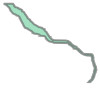

In [7]:
#load polygon data
data_path = '/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/' 
zone_name= 'release_zone_brazil.csv'


exterior = pd.read_csv(Path(data_path + zone_name)).values.tolist()
box_poly = Polygon(exterior, [])

box_poly

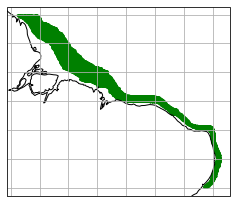

In [8]:
#generate lat lon values inside the polygon
in_poly = get_uniform_random_latlon_within_polygon(box_poly,N = number_particles, max_iter=55)

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
    figsize=(4, 4),
)

#ax.plot(box_poly.exterior.xy, transform=cartopy.crs.PlateCarree(), linewidth=1, color="blue")
in_poly.astype(float).plot.scatter(
        x="lon", y="lat", s=1, c="green",
        ax=ax, transform=cartopy.crs.PlateCarree()
        )

ax.coastlines()
ax.gridlines()

In [9]:
#random release time in time window (1st day of release week)
rel_time  = np.sort(
   dt.datetime.fromisocalendar(start_year, start_week,1)
    + dt.timedelta(minutes=dt_in_minutes) * np.random.randint(
        0,
        dt.timedelta(days=release_time_in_days) / dt.timedelta(minutes=dt_in_minutes),
        size=(number_particles, )
    )
)

#calc correct runtime
corr_runtime_in_days = runtime_in_days + release_time_in_days

depth = np.random.uniform(
    depth_min,
    depth_max, #lower boundary of box
    size=rel_time.shape
)


pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lat=in_poly.lat.values,
    lon=in_poly.lon.values,
    depth=depth,
    time=rel_time
) 
print(f"Created {len(pset)} particles.")

Created 40000 particles.


In [10]:
#Kernels and error handling

def DeleteParticle(particle, fieldset, time): 
    particle.delete()

recovery_cases = {
    ErrorCode.ErrorOutOfBounds: DeleteParticle
}

# config kernel here

custom_kernel = pset.Kernel(AdvectionRK4_3D)


In [11]:
#prepare Output
output_filenamepath = outpath + output_filename
print(output_filenamepath)

outputfile = pset.ParticleFile(
    name=output_filenamepath,
    outputdt=dt.timedelta(hours=outputdt_in_hours)
)

../output_data/full_brazil_longterm/urchin_americas_zone_2011_w01_RT-180_N-40000_seed-123.nc


In [11]:
#execute
pset.execute(
    custom_kernel,
    runtime=dt.timedelta(days=corr_runtime_in_days),
    dt=dt.timedelta(minutes=dt_in_minutes * timearrow),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
    output_file=outputfile,
)

outputfile.export()
outputfile.close()

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-729666/lib42a93a8b9a90801364bd3f0572b4d4f9_0.so
INFO: Temporary output files are stored in ../output_data/out-YUIIINVL.
INFO: You can use "parcels_convert_npydir_to_netcdf ../output_data/out-YUIIINVL" to convert these to a NetCDF file during the run.
100%|████████████████████████| 18144000.0/18144000.0 [15:57<00:00, 18957.05it/s]


In [1]:
!hostname

nesh-fe3
